In [1]:
from pylab import *
import gc
import pickle5 as pickle
import inspect

import healpy as hp
import numpy as np

from qubicpack.utilities import Qubic_DataDir
from pysimulators import FitsArray
import qubic
import qubic.lib.QskySim as qss
from qubic import SpectroImLib as si
from qubic import camb_interface as qc
from pysm3 import models
import pysm3

[proton:20067] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
#from torch_geometric.nn import GCNConv

from pygsp import graphs
#import torch_geometric.nn as gnn

import torch.distributed as dist
import torch.multiprocessing as mp

In [3]:
from pyoperators import MPIDistributionIdentityOperator, HomothetyOperator, DiagonalOperator, IdentityOperator, Rotation2dOperator, Rotation3dOperator, ReshapeOperator,BlockDiagonalOperator, DenseBlockDiagonalOperator, CompositionOperator
from pysimulators import ConvolutionTruncatedExponentialOperator, ProjectionOperator
from pysimulators.interfaces.healpy import Cartesian2HealpixOperator, HealpixConvolutionGaussianOperator
from qubic.ripples import ConvolutionRippledGaussianOperator

In [4]:
from pygsp import graphs, filters
from scipy import sparse

In [5]:
%matplotlib inline

In [6]:
dictfilename = 'qubic/qubic/dicts/pipeline_demo.dict'
d = qubic.lib.qubicDict()
d.read_from_file(dictfilename)

center = qubic.lib.equ2gal(d['RA_center'], d['DEC_center'])

In [8]:
d['nf_recon'] = 4
d['nf_sub'] = 4
d['MultiBand'] = True

d['synthbeam_kmax'] = 1
nf_sub = d['nf_sub']
d['synthbeam_fraction'] = 1

d['use_synthbeam_fits_file'] = False
d['noiseless'] = True
d['photon_noise'] = False
d['npointings'] = 8000
d['instrument_type'] = 'UWB'
nf_recon = d['nf_recon']

#### Zasad cemo koristit qss, posli nadji nacin za dodat prasinu priko CAMB ka u tod_to_comp_masked

#### Krecemo bez prasine i bez suma

In [13]:
d['nside'] = 128

In [9]:
seed = 3
sky_config = {'cmb': seed}
Qubic_sky = qss.Qubic_sky(sky_config, d)
sky_map = Qubic_sky.get_simple_sky_map()

setting the output map dtype to [dtype('float64'), dtype('float64'), dtype('float64')]


In [10]:
p = qubic.lib.get_pointing(d)
s = qubic.lib.QubicScene(d)
q = qubic.lib.QubicMultibandInstrument(d)

In [11]:
_, nus_edge, nus, _, _, _ = qubic.lib.compute_freq(d['filter_nu'] / 1e9, d['nf_sub'], d['filter_relative_bandwidth'])
nus

array([135.50540829, 144.29216391, 153.6486907 , 163.61193508])

In [12]:
multiacquisition = qubic.lib.QubicInstrumentType(d, nsub = 4, nrec = 4)

Info proton: Allocating (7936000,9) elements = 1.064300537109375 GiB in FSRRotation3dMatrix.__init__.
Info proton: Allocating (7936000,9) elements = 1.064300537109375 GiB in FSRRotation3dMatrix.__init__.
Info proton: Allocating (7936000,9) elements = 1.064300537109375 GiB in FSRRotation3dMatrix.__init__.
Info proton: Allocating (7936000,9) elements = 1.064300537109375 GiB in FSRRotation3dMatrix.__init__.


In [33]:
convolution = multiacquisition.subacqs[0].get_convolution_peak_operator()
convolved_sky_map = np.zeros(sky_map.shape)
for i in range(sky_map.shape[0]):
    convolved_map = convolution(sky_map[i])
    convolved_sky_map[i] = convolved_map

In [46]:
TOD_total = np.zeros((nf_recon, 992, 8000))
for i in range(len(multiacquisition.subacqs)):
    TOD_nsub = multiacquisition.subacqs[i].get_operator()(convolved_sky_map[i,:,:])
    TOD_total[i] = TOD_nsub

Info proton: Allocating (7936000,9) elements = 1.064300537109375 GiB in FSRRotation3dMatrix.__init__.
Info proton: Allocating (7936000,9) elements = 1.064300537109375 GiB in FSRRotation3dMatrix.__init__.
Info proton: Allocating (7936000,9) elements = 1.064300537109375 GiB in FSRRotation3dMatrix.__init__.
Info proton: Allocating (7936000,9) elements = 1.064300537109375 GiB in FSRRotation3dMatrix.__init__.


## Graph structure

In [49]:
def healpix_weightmatrix(nside=16, nest=True, indexes=None, dtype=np.float32):
    """Return an unnormalized weight matrix for a graph using the HEALPIX sampling.

    Parameters
    ----------
    nside : int
        The healpix nside parameter, must be a power of 2, less than 2**30.
    nest : bool, optional
        if True, assume NESTED pixel ordering, otherwise, RING pixel ordering
    indexes : list of int, optional
        List of indexes to use. This allows to build the graph from a part of
        the sphere only. If None, the default, the whole sphere is used.
    dtype : data-type, optional
        The desired data type of the weight matrix.
    """
    if not nest:
        raise NotImplementedError()

    if indexes is None:
        indexes = range(nside**2 * 12)
    npix = len(indexes)  # Number of pixels.
    if npix >= (max(indexes) + 1):
        # If the user input is not consecutive nodes, we need to use a slower
        # method.
        usefast = True
        indexes = range(npix)
    else:
        usefast = False
        indexes = list(indexes)

    # Get the coordinates.
    x, y, z = hp.pix2vec(nside, indexes, nest=nest)
    coords = np.vstack([x, y, z]).transpose()
    coords = np.asarray(coords, dtype=dtype)
    # Get the 7-8 neighbors.
    neighbors = hp.pixelfunc.get_all_neighbours(nside, indexes, nest=nest)
    # if use_4:
    #     print('Use 4')
    #     col_index = []
    #     row_index = []
    #     for el,neighbor in zip(indexes,neighbors.T):
    #         x, y, z = hp.pix2vec(nside, [el], nest=nest)
    #         coords_1 = np.vstack([x, y, z]).transpose()
    #         coords_1 = np.array(coords_1)

    #         x, y, z = hp.pix2vec(nside, neighbor, nest=nest)
    #         coords_2 = np.vstack([x, y, z]).transpose()
    #         coords_2 = np.asarray(coords_2)
    #         ind = np.argsort(np.sum((coords_2-coords_1)**2,axis=1),)[:4]
    #         col_index = col_index + neighbor[ind].tolist()
    #         row_index = row_index +[el]*4
    #     col_index = np.array(col_index)
    #     row_index = np.array(row_index)
    # else:
    # Indices of non-zero values in the adjacency matrix.
    col_index = neighbors.T.reshape((npix * 8))
    row_index = np.repeat(indexes, 8)

    # Remove pixels that are out of our indexes of interest (part of sphere).
    if usefast:
        keep = (col_index < npix)
        # Remove fake neighbors (some pixels have less than 8).
        keep &= (col_index >= 0)
        col_index = col_index[keep]
        row_index = row_index[keep]
    else:
        col_index_set = set(indexes)
        keep = [c in col_index_set for c in col_index]
        inverse_map = [np.nan] * (nside**2 * 12)
        for i, index in enumerate(indexes):
            inverse_map[index] = i
        col_index = [inverse_map[el] for el in col_index[keep]]
        row_index = [inverse_map[el] for el in row_index[keep]]

    # Compute Euclidean distances between neighbors.
    distances = np.sum((coords[row_index] - coords[col_index])**2, axis=1)
    # slower: np.linalg.norm(coords[row_index] - coords[col_index], axis=1)**2

    # Compute similarities / edge weights.
    kernel_width = np.mean(distances)
    weights = np.exp(-distances / (2 * kernel_width))

    # Similarity proposed by Renata & Pascal, ICCV 2017.
    # weights = 1 / distances

    # Build the sparse matrix.
    W = sparse.csr_matrix(
        (weights, (row_index, col_index)), shape=(npix, npix), dtype=dtype)

    # if use_4:
    #     W = (W+W.T)/2

    return W

In [50]:
def healpix_graph(nside=16,
                  nest=True,
                  lap_type='normalized',
                  indexes=None,
                  use_4=False,
                  dtype=np.float32):

    if indexes is None:
        indexes = range(nside**2 * 12)

    npix = hp.nside2npix(nside)  
    pix = range(npix)
    x, y, z = hp.pix2vec(nside, pix, nest=nest)
    coords = np.vstack([x, y, z]).transpose()[indexes]
    if use_4:
        raise NotImplementedError()
        W = build_matrix_4_neighboors(nside, indexes, nest=nest, dtype=dtype)
    else:
        W = healpix_weightmatrix(
            nside=nside, nest=nest, indexes=indexes, dtype=dtype)
    G = graphs.Graph(
        W,
        lap_type=lap_type,
        coords=coords)
    G.signal = np.zeros(len(indexes), dtype=dtype)
    return G

In [51]:
def get_nside_from_graph(G):
    npix = G.N  
    nside = int(np.sqrt(npix / 12))
    return nside

In [52]:
def get_high_coverage_indexes(cov_map, threshold=0.15):
    maxcov = np.max(cov_map)
    unseen = cov_map < maxcov * threshold
    seen_indexes = np.where(~unseen)[0]  
    return seen_indexes

In [53]:
def get_G_masked_by_cov(G, nside, cov_map, threshold=0.15):
    G_partial_list = []
    if len(cov_map.shape) == 1:
        seen_indexes = get_high_coverage_indexes(cov_map, threshold = treshold)
        G_partial = G.subgraph(seen_indexes)
        G_partial.signal = G.signal[seen_indexes]
        G_partial.det_TOD = G.det_TOD
        print(seen_indexes)
        return G_partial
    
    for row in cov_map:
        seen_indexes = get_high_coverage_indexes(row, nside, threshold=threshold)
        print(seen_indexes)
        G_partial = G.subgraph(seen_indexes)
        G_partial.signal = G.signal[seen_indexes]
        G_partial.det_TOD = G.det_TOD
        
        G_partial_list.append(G_partial)
    
    if cov_map.shape[0] == 1:
        return G_partial_list[0]
    
    return G_partial_list

In [54]:
def get_G_masked_by_cov(G, nside, cov_map, treshold = 0.15): #you have to provide one or the second
    seen_indexes = get_high_coverage_indexes(cov_map, threshold = treshold)
    seen_indexes = hp.ring2nest(nside, seen_indexes)
    G_partial = G.subgraph(seen_indexes)
    G_partial.signal = G.signal[seen_indexes]
    G_partial.coords = G.coords[seen_indexes]
    return G_partial

In [55]:
def plot_sky_3d(graph_map, elev=10, azim=0, edges=False, vmin = None, vmax = None):
    signal = graph_map.signal
    if isinstance(signal, torch.Tensor):
        signal = signal.detach().cpu().numpy()
    signal = signal.copy()
    
    
    if vmin is None:
        vmin = signal[signal != -1.6375e+30].min()
    if vmax is None:
        vmax = signal.max()

    graph_map.plotting.update(vertex_size=0.6)
    fig = plt.figure(figsize=[8, 6])
    ax = fig.add_subplot(111, projection='3d')
    
    graph_map.plot_signal(graph_map.signal, show_edges = False, ax=ax, limits = [vmin, vmax])

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    
    ax.view_init(elev=elev, azim=azim)
    plt.show()

In [56]:
seen_indexes = get_high_coverage_indexes(multiacquisition._get_coverage())
seen_indexes = hp.ring2nest(d['nside'], seen_indexes)

In [57]:
G = healpix_graph(d['nside'], indexes = seen_indexes)

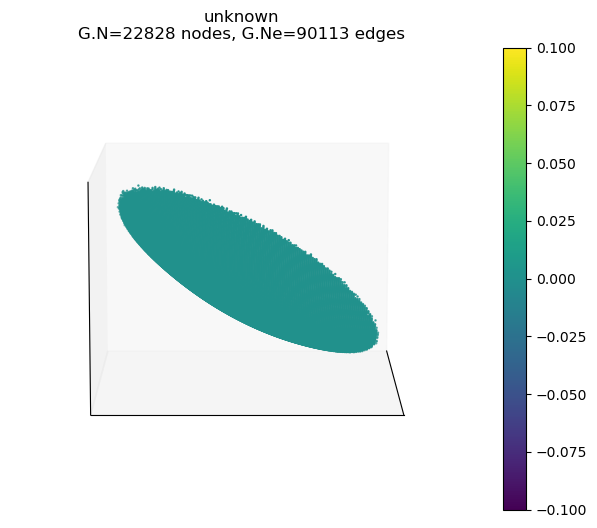

In [58]:
plot_sky_3d(G)

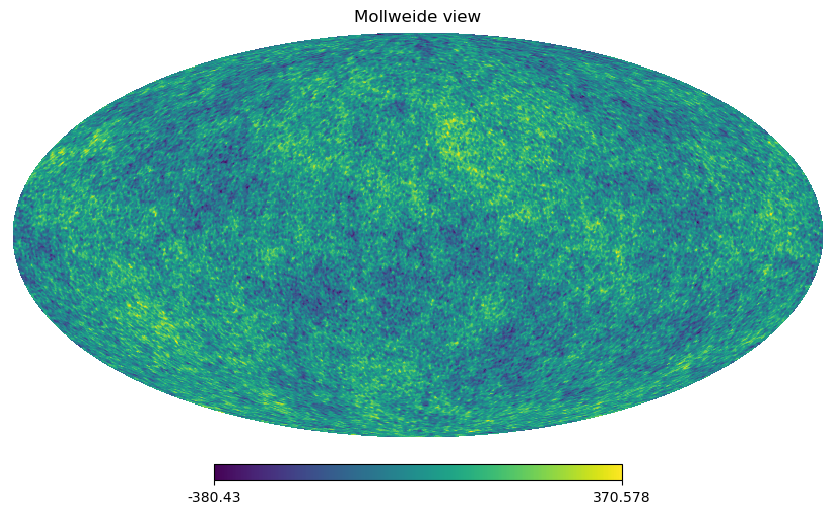

In [59]:
hp.mollview(convolved_sky_map[0,:,0])

In [60]:
input_map_reord = hp.reorder(convolved_sky_map[0,:,0], r2n=True)

G_sky = healpix_graph(nside=d['nside'], nest=True)

G_sky.signal = input_map_reord 

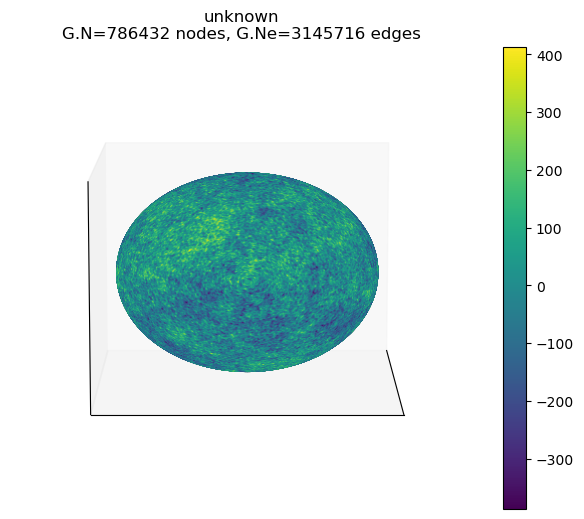

In [61]:
plot_sky_3d(G_sky)

In [62]:
G_sky_partial = G_sky.subgraph(seen_indexes)
G_sky_partial.signal = G_sky.signal[seen_indexes]

In [63]:
#### ode je razlika izmedju stare i nove verzije!!!

In [64]:
G_sky_partial.coords = G_sky.coords[seen_indexes]

In [65]:
G_sky_partial.coords

array([[ 0.54711748, -0.55387316, -0.62760417],
       [ 0.55721978, -0.54370868, -0.62760417],
       [ 0.56713328, -0.53335997, -0.62760417],
       ...,
       [ 0.14484376, -0.13779518, -0.97981262],
       [ 0.15153223, -0.13040403, -0.97981262],
       [ 0.16657114, -0.11054991, -0.97981262]])

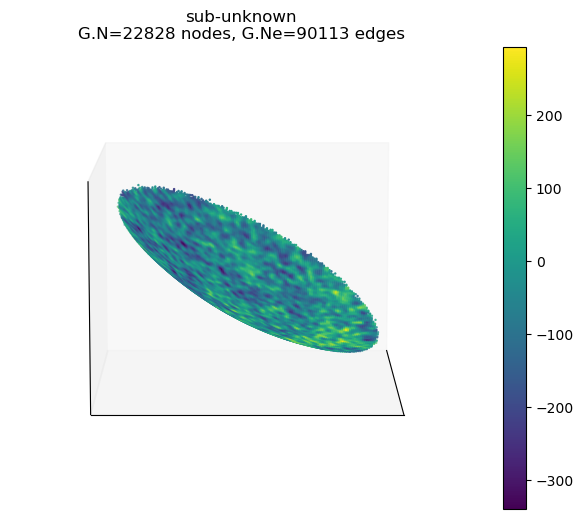

In [66]:
plot_sky_3d(G_sky_partial)

## Multifeature Graph Structure

In [67]:
def healpix_weightmatrix_multifeature(nside=16, nest=True, indexes=None, dtype=np.float32):
    if not nest:
        raise NotImplementedError()

    if indexes is None:
        indexes = range(nside**2 * 12)
    npix = len(indexes)  # Number of pixels.
    if npix >= (max(indexes) + 1):
        usefast = True
        indexes = range(npix)
    else:
        usefast = False
        indexes = list(indexes)

    x, y, z = hp.pix2vec(nside, indexes, nest=nest)
    coords = np.vstack([x, y, z]).transpose()
    coords = np.asarray(coords, dtype=dtype)
    
    neighbors = hp.pixelfunc.get_all_neighbours(nside, indexes, nest=nest)

    col_index = neighbors.T.reshape((npix * 8))
    row_index = np.repeat(indexes, 8)

    if usefast:
        keep = (col_index < npix)
        keep &= (col_index >= 0)
        col_index = col_index[keep]
        row_index = row_index[keep]
    else:
        col_index_set = set(indexes)
        keep = [c in col_index_set for c in col_index]
        inverse_map = [np.nan] * (nside**2 * 12)
        for i, index in enumerate(indexes):
            inverse_map[index] = i
        col_index = [inverse_map[el] for el in col_index[keep]]
        row_index = [inverse_map[el] for el in row_index[keep]]

    distances = np.sum((coords[row_index] - coords[col_index])**2, axis=1)
    kernel_width = np.mean(distances)
    weights = np.exp(-distances / (2 * kernel_width))

    W = sparse.csr_matrix(
        (weights, (row_index, col_index)), shape=(npix, npix), dtype=dtype)

    return W

In [68]:
def healpix_graph_multifeature(nside=16, nest=True, lap_type='normalized', indexes=None, use_4=False, dtype=np.float32):
    if indexes is None:
        indexes = range(nside**2 * 12)

    npix = hp.nside2npix(nside)  
    pix = range(npix)
    x, y, z = hp.pix2vec(nside, pix, nest=nest)
    coords = np.vstack([x, y, z]).transpose()[indexes]
    
    W = healpix_weightmatrix_multifeature(nside=nside, nest=nest, indexes=indexes, dtype=dtype)
    G = graphs.Graph(W, lap_type=lap_type, coords=coords)
    G.signal = np.zeros((len(indexes), 4), dtype=dtype)  # 4 features: I, Q, U, Coverage
    return G

In [69]:
def get_G_masked_by_cov_multifeature(G, nside, cov_map, threshold=0.15):
    seen_indexes = get_high_coverage_indexes(cov_map, threshold=threshold)
    seen_indexes = hp.ring2nest(nside, seen_indexes)
    G_partial = G.subgraph(seen_indexes)
    G_partial.signal = G.signal[seen_indexes]
    G_partial.coords = G.coords[seen_indexes]
    return G_partial

In [70]:
def plot_sky_3d_multifeature(graph_map, feature_index=0, elev=10, azim=0, edges=False, vmin=None, vmax=None):
    signal = graph_map.signal[:, feature_index]  # Select the feature to plot
    if isinstance(signal, torch.Tensor):
        signal = signal.detach().cpu().numpy()
    signal = signal.copy()
    
    if vmin is None:
        vmin = signal[signal != -1.6375e+30].min()
    if vmax is None:
        vmax = signal.max()

    graph_map.plotting.update(vertex_size=0.6)
    fig = plt.figure(figsize=[8, 6])
    ax = fig.add_subplot(111, projection='3d')
    
    graph_map.plot_signal(signal, show_edges=edges, ax=ax, limits=[vmin, vmax])

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    
    ax.view_init(elev=elev, azim=azim)
    plt.show()

In [71]:
G_sky_multifeature = healpix_graph_multifeature(nside=d['nside'], nest=True)

In [72]:
input_map_reord_multifeature = np.zeros((convolved_sky_map.shape))

In [73]:
input_map_reord_multifeature[0,:,0] = hp.reorder(convolved_sky_map[0,:,0], r2n=True)
input_map_reord_multifeature[0,:,1] = hp.reorder(convolved_sky_map[0,:,1], r2n=True)
input_map_reord_multifeature[0,:,2] = hp.reorder(convolved_sky_map[0,:,2], r2n=True)

In [74]:
G_sky_multifeature.signal = input_map_reord_multifeature[0,:,:]

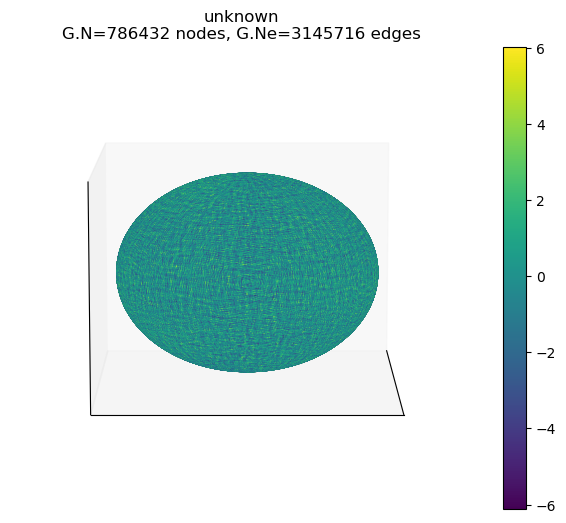

In [75]:
plot_sky_3d_multifeature(G_sky_multifeature, feature_index=1)